<a href="https://colab.research.google.com/github/ajeunel/Risk_Assessment_Bias/blob/main/Capstone_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cleaning dataset

In [ ]:
## Cleaning the dataset to only include demographic factors, housing destinantion and total score.

import pandas as pd

# 1) Read raw data
df = pd.read_csv("SPDAT_Dataset.csv")

# 1.1) Rename 'intervention' → 'housing_destination'
df.rename(columns={'Intervention': 'Housing_destination'}, inplace=True)

# 2) Filter only Male/Female
df = df[df['Gender'].isin(['Male','Female'])]

# 3) Filter to wanted races
only_races = ['White','Black','Latino','Asian']
df = df[df['Race/Ethnicity'].isin(only_races)]

df = df.dropna(subset=['Age_group_at_assessment'])

remove_other_age_groups = ['Under 18']
df = df[~df['Age_group_at_assessment'].isin(remove_other_age_groups)]

# 5) Select only the columns you need
df = df[
    ['Unique_client_ID',
     'Race/Ethnicity',
     'Gender',
     'Age_group_at_assessment',
     'TOTAL_SCORE',
     'Housing_destination']
]

# 6) Reset index
df.reset_index(drop=True, inplace=True)

# 7) Export cleaned CSV
df.to_csv('vispdat_cleaned.csv', index=False)



## After cleaning this dataset, statistical analysis and exploratory data analysis was done in R. Please refer to Github repository to view.


## DATA PREPARATION/ ADDING DUMMY DATA


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1) Load and prepare
df = pd.read_csv("vispdat_cleaned.csv")
df['is_perm_housed'] = df['Housing_destination'].isin(["Permanently Housed"]).astype(int)
df["Race/Ethnicity"] = pd.Categorical(
    df["Race/Ethnicity"],
    categories=["White","Black","Latino","Asian"],
    ordered=False
)
df["Age_group_at_assessment"] = pd.Categorical(
    df["Age_group_at_assessment"],
    categories=["18-24", "26-44", "45-59", "60+"],
    ordered=False
)

# 2) Define features/target
X = df[['TOTAL_SCORE','Race/Ethnicity','Gender','Age_group_at_assessment']]
y = df['is_perm_housed']

# 3) Creating dummy data. This is lengthy but I ran into issues with encoding dropping the first catagory
#.. and not allowing me to specify the reference groups (see paper for explanation)
df['Gender_Female'] = (df['Gender'] == 'Female').astype(int)

# 3) Create race dummies, omitting 'White' as the reference
df['Race_Black']    = (df['Race/Ethnicity'] == 'Black').astype(int)
df['Race_Latino'] = (df['Race/Ethnicity'] == 'Latino').astype(int)
df['Race_Asian']    = (df['Race/Ethnicity'] == 'Asian').astype(int)

#Age Dummy data
df['Age_Youth'] = (df['Age_group_at_assessment'] == '18-24').astype(int)
df['Age_GenX'] = (df['Age_group_at_assessment'] == '45-59').astype(int)
df['Age_Boomer'] = (df['Age_group_at_assessment'] == '60+').astype(int)


# 4) Now df has four new columns: Gender_Male, Race_Black, Race_Hispanic, Race_Asian

print(df[['Gender_Female', 'Race_Black', 'Race_Latino', 'Race_Asian','Age_Youth','Age_GenX','Age_Boomer']].head())
df.to_csv('SPDAT_scores_with_dummy.csv', index=False)


   Gender_Female  Race_Black  Race_Latino  Race_Asian  Age_Youth  Age_GenX  \
0              1           0            1           0          0         0   
1              0           0            1           0          0         0   
2              0           0            0           0          0         1   
3              0           1            0           0          0         1   
4              1           1            0           0          0         0   

   Age_Boomer  
0           0  
1           0  
2           0  
3           0  
4           1  


In [ ]:
# 4) Fit & inspect coefficients
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# 1) Load your filtered, dummy-augmented DataFrame
df = df.drop(columns=["Gender", "Race/Ethnicity","Age_group_at_assessment"])

# 3) Define X & y
features = [
    "Gender_Female",
    "Race_Black",
    "Race_Latino",
    "Race_Asian",
    "TOTAL_SCORE",
    "Age_Youth",
    "Age_GenX",
    "Age_Boomer"
]
X = df[features]
y = df['Housing_destination'].isin(["Permanently Housed"]).astype(int)

# 4a) Quick sklearn fit
clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)

print("Sklearn coefficients:")
for feat, coef in zip(features, clf.coef_[0]):
    print(f"  {feat}: {coef:.3f}")

# 4b) Or for a statsmodels summary
X2 = sm.add_constant(X)   # adds intercept term
logit = sm.Logit(y, X2).fit(disp=False)
print(logit.summary())



Sklearn coefficients:
  Gender_Female: 0.133
  Race_Black: 0.315
  Race_Latino: -0.074
  Race_Asian: 0.012
  TOTAL_SCORE: 0.006
  Age_Youth: 0.414
  Age_GenX: 0.384
  Age_Boomer: 0.597
                            Logit Regression Results                           
Dep. Variable:     Housing_destination   No. Observations:               129294
Model:                           Logit   Df Residuals:                   129285
Method:                            MLE   Df Model:                            8
Date:                 Sat, 26 Apr 2025   Pseudo R-squ.:                 0.01471
Time:                         19:11:20   Log-Likelihood:                -65571.
converged:                        True   LL-Null:                       -66550.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const      

## Log. Regression Model (no subscores)

Confusion matrix:
 [[20414     0]
 [ 5445     0]] 

                        precision    recall  f1-score   support

Not Permanently Housed       0.79      1.00      0.88     20414
    Permanently Housed       0.00      0.00      0.00      5445

              accuracy                           0.79     25859
             macro avg       0.39      0.50      0.44     25859
          weighted avg       0.62      0.79      0.70     25859

Test AUC: 0.586


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


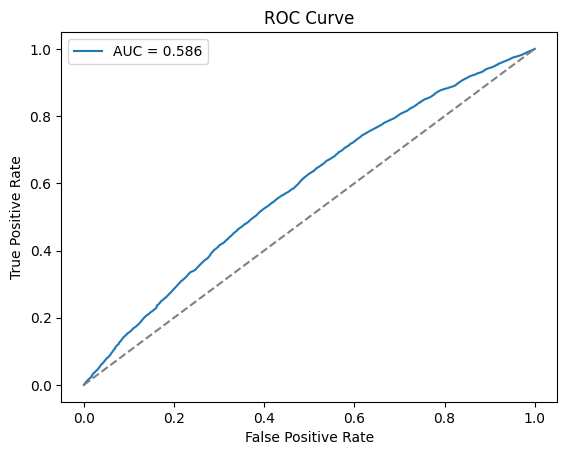

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model     import LogisticRegression
from sklearn.metrics          import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot       as plt

# a) Split out a test set - 80/20 split
X = df[["Gender_Female","Race_Black","Race_Latino","Race_Asian","Age_Youth","Age_GenX","Age_Boomer","TOTAL_SCORE"]]
y = df['Housing_destination'].isin(["Permanently Housed"]).astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# b) Fit logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# c) Predict and get probabilities
y_pred     = clf.predict(X_test)
y_proba    = clf.predict_proba(X_test)[:,1]

# d) Confusion matrix & classification report
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm, "\n")
print(classification_report(y_test, y_pred,
      target_names=["Not Permanently Housed","Permanently Housed"]))

# e) ROC AUC
auc = roc_auc_score(y_test, y_proba)
print(f"Test AUC: {auc:.3f}")

# f) (Optional) Plot ROC curve
fpr,tpr,_ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
## FEATURE ENRICHMENT FOR THE LOG REGRESSION

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model     import LogisticRegression
from sklearn.metrics          import (
    confusion_matrix,
    roc_auc_score,
    classification_report
)

# 1) Load the merged data
df = pd.read_csv("/content/SPDAT_with_scores.csv")

# 2) Define your feature columns
features = [
    # Demographic dummies
    "Gender_Female",
    "Race_Black", "Race_Latino", "Race_Asian",
    # Age-group dummies (assuming you have 26-54, 55-64, 65+)
    "Age_Youth", "Age_GenX", "Age_Boomer",
    # Assessment score
    "TOTAL_SCORE",
    # Wellness subscores
    "HISTORY_SUB_SCORE", "RISKS_SUB_SCORE",
    "SOCIALIZATION_SUB_SCORE", "WELLNESS_SUB_SCORE"
]

# 3) Build X and y
X = df[features]
y = (df["Housing_destination"] == "Permanently Housed").astype(int)

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


##RERUN LOGISTIC REGRESSION

# 5) Fit a simple logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 6) Evaluate on the test set
y_pred  = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred), "\n")

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=["Not Perm","Perm"]))

auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc:.3f}")



Confusion matrix:
[[20414     0]
 [ 5445     0]] 

Classification report:
              precision    recall  f1-score   support

    Not Perm       0.79      1.00      0.88     20414
        Perm       0.00      0.00      0.00      5445

    accuracy                           0.79     25859
   macro avg       0.39      0.50      0.44     25859
weighted avg       0.62      0.79      0.70     25859

ROC AUC: 0.597


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Random Forest Model (no subscores)

In [ ]:
from sklearn.ensemble      import RandomForestClassifier
from sklearn.metrics       import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

# 1) Split (reuse your X, y from before)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Fit a Random Forest with class weights to handle imbalance
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

# 3) Predict & evaluate
y_pred  = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

print("RF AUC:",   roc_auc_score(y_test, y_proba))
print("RF CM:\n", confusion_matrix(y_test, y_pred))


RF AUC: 0.5611503493839145
RF CM:
 [[12784  7630]
 [ 2837  2608]]


In [ ]:

##WONT RUN This is hyperparameter tuning for the random forest model.
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble      import RandomForestClassifier

param_grid = {
  'n_estimators': [100, 200, 500],
  'max_depth': [None, 5, 10],
  'min_samples_leaf': [1, 5, 10]
}
gs = GridSearchCV(
  RandomForestClassifier(class_weight='balanced', random_state=42),
  param_grid, cv=3, scoring='roc_auc', n_jobs=-1
).fit(X_train, y_train)
print(gs.best_params_, '→ AUC:', roc_auc_score(y_test, gs.predict_proba(X_test)[:,1]))



KeyboardInterrupt: 

## Gradient boosting (no subscores)

In [ ]:
### REDUNDANT TO THE OTHER CELL BUT KEEPING JUST IN CASE. REVIEW AGAIN!!!!!!!!

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=100,  # or 200, or 500 - choose one
    learning_rate=0.1, # or 0.01, or 0.05 - choose one
    max_depth=3,       # or 5, or 7 - choose one
    min_samples_leaf=1 # or 5, or 10 - choose one
)
gb.fit(X_train, y_train)

y_pred_gb  = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:,1]

print("GB AUC:",   roc_auc_score(y_test, y_proba_gb))
print("GB CM:\n",  confusion_matrix(y_test, y_pred_gb))

from sklearn.metrics import roc_curve, confusion_matrix

# y_proba from your GBM or RF: P(Permanent)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Choose the threshold that maximizes tpr - fpr (Youden’s J)
best_idx    = (tpr - fpr).argmax()
best_thresh = thresholds[best_idx]
print("Best threshold:", best_thresh)

# Recompute predictions at that threshold
y_pred_adj = (y_proba >= best_thresh).astype(int)
print("Confusion matrix @ best_thresh:\n",
      confusion_matrix(y_test, y_pred_adj))
from sklearn.metrics import classification_report
print(classification_report(
    y_test, y_pred_adj,
    target_names=["Not Permanent","Permanent"]
))



GB AUC: 0.6052611987865869
GB CM:
 [[20413     1]
 [ 5445     0]]
Best threshold: 0.19213457865885725
Confusion matrix @ best_thresh:
 [[ 9481 10933]
 [ 1675  3770]]
               precision    recall  f1-score   support

Not Permanent       0.85      0.46      0.60     20414
    Permanent       0.26      0.69      0.37      5445

     accuracy                           0.51     25859
    macro avg       0.55      0.58      0.49     25859
 weighted avg       0.72      0.51      0.55     25859



## Gradient Boosting Model with Subscores #highest AUC

In [ ]:
import pandas as pd
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics         import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

features = [
    # Demographic dummies
    "Gender_Female",
    "Race_Black", "Race_Latino", "Race_Asian",
    # Age-group dummies (assuming you have 26-54, 55-64, 65+)
    "Age_Youth", "Age_GenX", "Age_Boomer",
    # Assessment score
    "TOTAL_SCORE",
    # Wellness subscores
    "HISTORY_SUB_SCORE", "RISKS_SUB_SCORE",
    "SOCIALIZATION_SUB_SCORE", "WELLNESS_SUB_SCORE"
]
X = df[features]
y = (df["Housing_destination"] == "Permanently Housed").astype(int)

# 3) Split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4) Fit a GBM classifier
gb = GradientBoostingClassifier(
    n_estimators=200,     # number of trees
    learning_rate=0.05,   # step size shrinkage
    max_depth=3,          # tree depth
    random_state=42
)
gb.fit(X_train, y_train)

# 5) Compute AUC on test set
y_proba = gb.predict_proba(X_test)[:,1]   # proba of “Permanent”
auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC AUC: {auc:.3f}")

# 6) Show confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred), "\n")
print(classification_report(
    y_test, y_pred,
    target_names=["Not Permanent","Permanent"]
))


Test ROC AUC: 0.605
Confusion Matrix:
[[ 9481 10933]
 [ 1675  3770]] 

               precision    recall  f1-score   support

Not Permanent       0.85      0.46      0.60     20414
    Permanent       0.26      0.69      0.37      5445

     accuracy                           0.51     25859
    macro avg       0.55      0.58      0.49     25859
 weighted avg       0.72      0.51      0.55     25859



In [ ]:
for col in ["Race_Black","Race_Latino","Race_Asian"]:
    mask = X_test[col] == 1
    # Filter y_pred to match the masked y_test
    y_pred_masked = y_pred[mask]
    tn, fp, fn, tp = confusion_matrix(y_test[mask], y_pred_masked).ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    print(f"{col}: FPR={fpr:.2%}, FNR={fnr:.2%}")



Race_Black: FPR=78.26%, FNR=12.41%
Race_Latino: FPR=31.51%, FNR=53.93%
Race_Asian: FPR=48.56%, FNR=43.75%


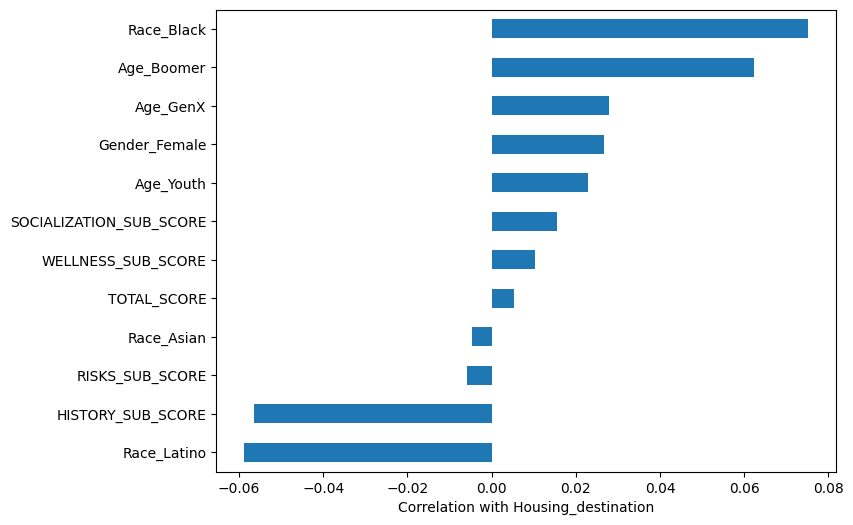

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
##Which features contribute most to permant housing??

# Convert 'Housing_destination' to numeric using binary encoding
# Assuming 'Permanently Housed' is the positive class (1)
df['Housing_destination_numeric'] = (df['Housing_destination'] == 'Permanently Housed').astype(int)

# Calculate correlation with the numeric version
corr_values = df[features].corrwith(df["Housing_destination_numeric"])
corr_values.sort_values().plot(kind='barh', figsize=(8,6))
plt.xlabel("Correlation with Housing_destination")
plt.show()


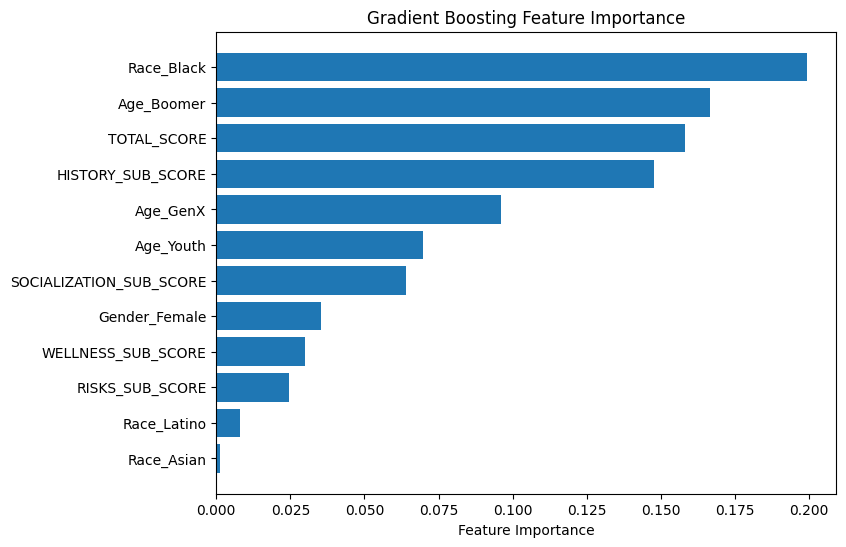

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

feature_importances = gb.feature_importances_
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(8,6))
plt.barh(np.array(features)[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Feature Importance")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize TOTAL_SCORE and subscores so they have more influence
score_features = [
    "TOTAL_SCORE", "HISTORY_SUB_SCORE", "RISKS_SUB_SCORE",
    "SOCIALIZATION_SUB_SCORE", "WELLNESS_SUB_SCORE"
]
scaler = StandardScaler()
df[score_features] = scaler.fit_transform(df[score_features])


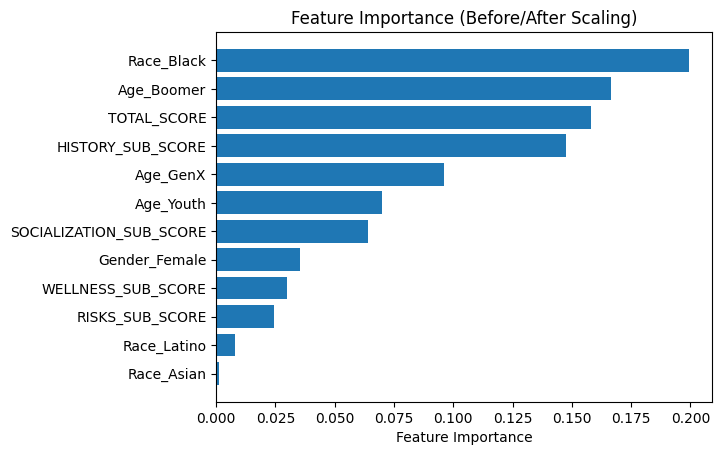

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = gb.feature_importances_
sorted_idx = np.argsort(feature_importances)

plt.barh(np.array(features)[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance (Before/After Scaling)")
plt.show()


## WITH INTERACTIONS

In [ ]:

import pandas as pd
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics         import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

features = [
    # Demographic dummies
    "Gender_Female",
    "Race_Black", "Race_Latino", "Race_Asian",
    # Age-group dummies (assuming you have 26-54, 55-64, 65+)
    "Age_Youth", "Age_GenX", "Age_Boomer",
    # Assessment score
    "TOTAL_SCORE",
    # Wellness subscores
    "HISTORY_SUB_SCORE", "RISKS_SUB_SCORE",
    "SOCIALIZATION_SUB_SCORE", "WELLNESS_SUB_SCORE"
]

# Create Race-Gender interaction
df["Race_Gender"] = df["Race_Black"].astype(str) + "_" + df["Gender_Female"].astype(str)

# Generate interaction terms between Race-Gender, Age, and Scores
age_groups = ["Age_Youth", "Age_GenX", "Age_Boomer"]
score_features = ["TOTAL_SCORE", "HISTORY_SUB_SCORE", "RISKS_SUB_SCORE", "SOCIALIZATION_SUB_SCORE", "WELLNESS_SUB_SCORE"]

interaction_features = []  # Track new features to add

for age in age_groups:
    for score in score_features:
        interaction_col = f"{score}_x_{age}_RaceGender"
        df[interaction_col] = df[score] * df[age] * df["Race_Gender"].astype(float)
        interaction_features.append(interaction_col)  # Save interaction column name

# Add interactions to the features list
features.extend(interaction_features)

X = df[features]
y = (df["Housing_destination"] == "Permanently Housed").astype(int)

# 3) Split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4) Fit a GBM classifier
gb = GradientBoostingClassifier(
    n_estimators=200,     # number of trees
    learning_rate=0.05,   # step size shrinkage
    max_depth=3,          # tree depth
    random_state=42
)
gb.fit(X_train, y_train)

# 5) Compute AUC on test set
y_proba = gb.predict_proba(X_test)[:,1]   # proba of “Permanent”
auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC AUC: {auc:.3f}")

# 6) Show confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred), "\n")
print(classification_report(
    y_test, y_pred,
    target_names=["Not Permanent","Permanent"]
))




NameError: name 'df' is not defined

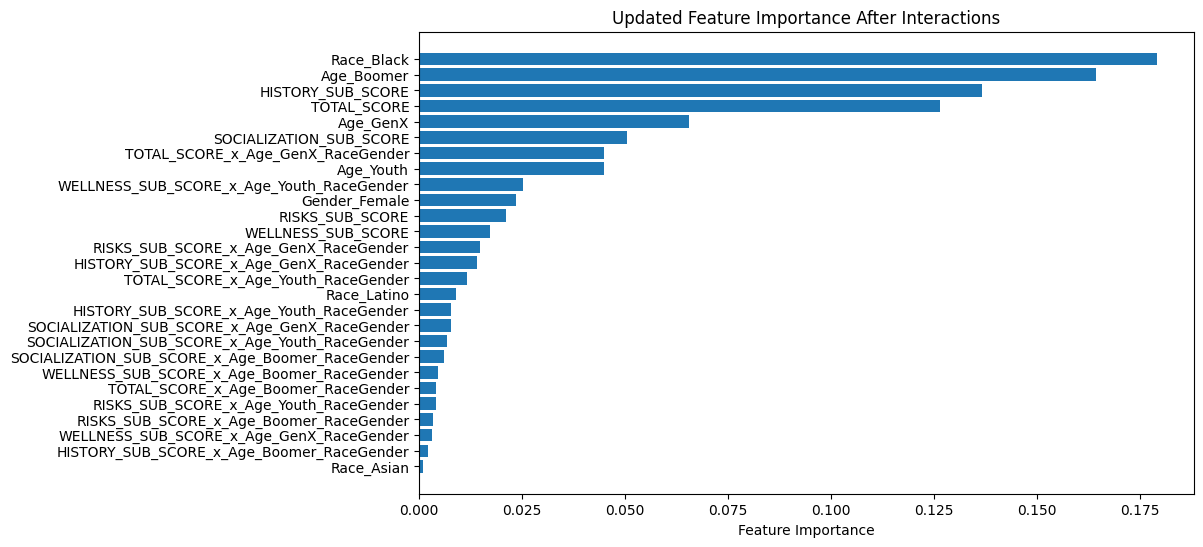

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importance from the trained model
feature_importances = gb.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Updated Feature Importance After Interactions")
plt.show()

## Removing interactions and Conducting Fairness test

In [ ]:
import pandas as pd
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics         import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

features = [
    # Demographic dummies
    "Gender_Female",
    "Race_Black", "Race_Latino", "Race_Asian",
    # Age-group dummies (assuming you have 26-54, 55-64, 65+)
    "Age_Youth", "Age_GenX", "Age_Boomer",
    # Assessment score
    "TOTAL_SCORE",
    # Wellness subscores
    "HISTORY_SUB_SCORE", "RISKS_SUB_SCORE",
    "SOCIALIZATION_SUB_SCORE", "WELLNESS_SUB_SCORE"
]
X = df[features]
y = (df["Housing_destination"] == "Permanently Housed").astype(int)

# 3) Split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4) Fit a GBM classifier
gb = GradientBoostingClassifier(
    n_estimators=200,     # number of trees
    learning_rate=0.05,   # step size shrinkage
    max_depth=4,
    min_samples_leaf=10,# tree depth
    random_state=42
)
gb.fit(X_train, y_train)

# 5) Compute AUC on test set
y_proba = gb.predict_proba(X_test)[:,1]   # proba of “Permanent”
auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC AUC: {auc:.3f}")

# 6) Show confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred), "\n")
print(classification_report(
    y_test, y_pred,
    target_names=["Not Permanent","Permanent"]
))

#Assign y_proba to the test portion of the DataFrame, aligning on index
#Assign y_proba to the test portion of the DataFrame, aligning on index
df_test = df.loc[X_test.index]
df_test['y_proba'] = y_proba
df_test.groupby("Race_Black")[["TOTAL_SCORE", "y_proba"]].mean() # Changed df to df_test


Test ROC AUC: 0.605
Confusion Matrix:
[[ 9481 10933]
 [ 1675  3770]] 

               precision    recall  f1-score   support

Not Permanent       0.85      0.46      0.60     20414
    Permanent       0.26      0.69      0.37      5445

     accuracy                           0.51     25859
    macro avg       0.55      0.58      0.49     25859
 weighted avg       0.72      0.51      0.55     25859



,TOTAL_SCORE,y_proba
Race_Black,,
0,0.062748,0.184540
1,-0.102560,0.245678


In [ ]:
df_test["Score_Bins"]= pd.cut(df_test["TOTAL_SCORE"], bins=[0, 3, 7, 17], labels=["Low", "Medium", "High"])

# Compare predicted housing likelihood across racial groups at equal scores
race_score_comparison = df_test.groupby(["Score_Bins", "Race_Black", "Race_Latino", "Race_Asian"])[["TOTAL_SCORE", "y_proba"]].mean()
print(race_score_comparison)


                                              TOTAL_SCORE   y_proba
Score_Bins Race_Black Race_Latino Race_Asian                       
Low        0          0           0              0.830883  0.195136
                                  1              0.742437  0.200320
                      1           0              0.799884  0.174710
                                  1                   NaN       NaN
           1          0           0              0.773583  0.250687
                                  1                   NaN       NaN
                      1           0                   NaN       NaN
                                  1                   NaN       NaN
Medium     0          0           0                   NaN       NaN
                                  1                   NaN       NaN
                      1           0                   NaN       NaN
                                  1                   NaN       NaN
           1          0           0             

<ipython-input-132-ad7027f1ad44>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_score_comparison = df_test.groupby(["Score_Bins", "Race_Black", "Race_Latino", "Race_Asian"])[["TOTAL_SCORE", "y_proba"]].mean()


In [ ]:
import pandas as pd
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics         import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
features = [
    # Demographic dummies
    "Gender_Female",
    "Race_Black", "Race_Latino", "Race_Asian",
    # Age-group dummies (assuming you have 26-54, 55-64, 65+)
    "Age_Youth", "Age_GenX", "Age_Boomer",
    # Assessment score
    "TOTAL_SCORE",
    # Wellness subscores
    "HISTORY_SUB_SCORE", "RISKS_SUB_SCORE",
    "SOCIALIZATION_SUB_SCORE", "WELLNESS_SUB_SCORE"
]
X = df[features]
y = (df["Housing_destination"] == "Permanently Housed").astype(int)

# 3) Split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4) Fit a GBM classifier
gb = GradientBoostingClassifier(
    n_estimators=200,     # number of trees
    learning_rate=0.05,   # step size shrinkage
    max_depth=4,
    min_samples_leaf=10,# tree depth
    random_state=42
)

from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights for balancing classes
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Train Gradient Boosting with sample weights
gb.fit(X_train, y_train, sample_weight=sample_weights)

from sklearn.metrics import roc_auc_score

y_proba = gb.predict_proba(X_test)[:, 1]  # Get predicted probabilities
auc_score = roc_auc_score(y_test, y_proba)

print("Updated AUC after Sample Weights:", auc_score)


Updated AUC after Sample Weights: 0.6053075532977917


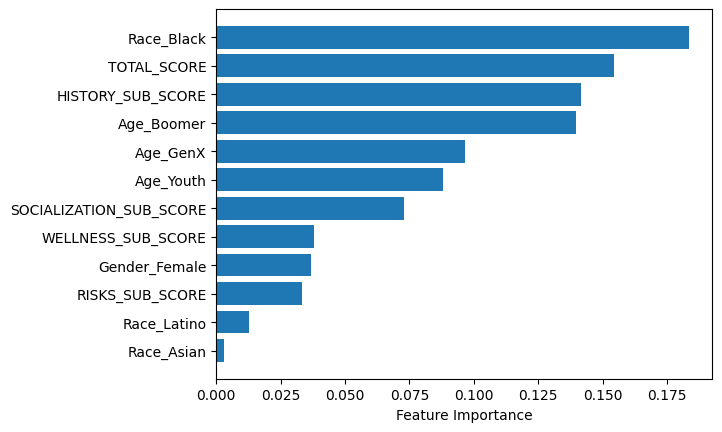

In [ ]:
##Test if race is the issue

features = [f for f in features if not ("Race" in f and "_x_" in f)]
import matplotlib.pyplot as plt
feature_importances = gb.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(np.array(features)[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.show()



In [ ]:
## LASSO
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

print("Selected Features:", X_train.columns[lasso.coef_ != 0])

from sklearn.metrics import roc_auc_score

y_proba_lasso = lasso.predict(X_test)
auc_lasso = roc_auc_score(y_test, y_proba_lasso)
print("Lasso AUC:", auc_lasso)





/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.451855202580191, tolerance: 1.3720885036496289
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.17319238430173, tolerance: 1.3720885036496289
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138.16516829170905, tolerance: 1.3720885036496289
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Convergenc

Selected Features: Index(['Gender_Female', 'Race_Black', 'Race_Latino', 'Age_Youth', 'Age_GenX',
       'Age_Boomer', 'TOTAL_SCORE', 'HISTORY_SUB_SCORE', 'RISKS_SUB_SCORE',
       'SOCIALIZATION_SUB_SCORE', 'WELLNESS_SUB_SCORE'],
      dtype='object')
Lasso AUC: 0.5964605215653962


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.836e+03, tolerance: 1.719e+00
  model = cd_fast.enet_coordinate_descent(


## Regularization Attempts

In [ ]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
ridge.fit(X_train, y_train)

# Print Ridge feature coefficients
print("Feature Coefficients:", ridge.coef_)
from sklearn.metrics import roc_auc_score


y_proba_ridge = ridge.predict(X_test)
auc_ridge = roc_auc_score(y_test, y_proba_ridge)
print("Ridge AUC:", auc_ridge)


Feature Coefficients: [ 0.02083991  0.05511516 -0.00769035 -0.0005197   0.06223116  0.05728987
 -0.01274531  0.4327393  -0.09268267 -0.15862461 -0.12249083 -0.19514748]
Ridge AUC: 0.5965120940516614


## New File to Reveal insights #Please see ReadME for explanation

In [ ]:
# Generate predicted probabilities for the test dataset
y_proba = model.predict_proba(X_test)[:, 1]

# Create a DataFrame with Unique Client ID and y_proba
df_y_proba = pd.DataFrame({
    "Unique_client_ID": df.loc[X_test.index, "Unique_client_ID"],  # Match IDs with test index
    "y_proba": y_proba
})

# Save to CSV for manual merging
df_y_proba.to_csv("y_proba_only.csv", index=False)

# Check output
print(df_y_proba.tail())



        Unique_client_ID   y_proba
64883              81676  0.394028
69414              87356  0.437616
53339              66658  0.242557
9037               10363  0.337589
103422            129631  0.222468


In [ ]:
print(df.loc[X_test.index, "Housing_destination"].value_counts())

X_test_housed = X_test[df.loc[X_test.index, "Housing_destination"] == "Permanently Housed"]
y_proba_housed = model.predict_proba(X_test_housed)[:, 1]


Housing_destination
Exited to an other or unknown destination                                                          7368
Permanently Housed                                                                                 5445
Matched to Permanent Housing, Not Yet Housed                                                       2680
Assessed Only                                                                                      2305
Exited to a place not meant for habitation                                                         1827
Exited to a temporary destination                                                                  1249
Currently active in "Street Outreach" program                                                      1208
Currently active in "Services Only" program                                                        1179
Currently active in "Emergency Shelter" program                                                     704
Currently active in "Coordinated Entry" prog

In [ ]:
import pandas as pd
df = pd.read_csv("SPDAT_with_scores.csv")

df["Housing_status"] = (df["Housing_destination"] == "Permanently Housed").astype(int)
features = ["TOTAL_SCORE", "HISTORY_SUB_SCORE", "RISKS_SUB_SCORE",
            "SOCIALIZATION_SUB_SCORE", "WELLNESS_SUB_SCORE",
            "Gender_Female", "Race_Black", "Race_Latino", "Race_Asian",
            "Age_Youth", "Age_GenX", "Age_Boomer"]

X = df[features]
y = df["Housing_status"]
from sklearn.model_selection import train_test_split

# Stratified split to maintain balance between housed vs. non-housed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
from xgboost import XGBClassifier

# Train XGBoost for flexible learning
model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=5)
model.fit(X_train, y_train)





XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.model_selection import train_test_split

# Stratified split to maintain balance between housed vs. non-housed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
from xgboost import XGBClassifier

# Train XGBoost with all features
model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=5)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Get predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate AUC Score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_proba)

print("Updated AUC:", auc)


Updated AUC: 0.6024686105063208


In [ ]:
df_results = df.loc[X_test.index, ["Unique_client_ID"]].copy()
df_results["y_proba"] = y_proba
df_results.to_csv("Tableau_Cleaned_Data333.csv", index=False)


In [ ]:
df_filtered = df_results[df.loc[X_test.index, "Housing_destination"] == "Permanently Housed"]
df_filtered.to_csv("Tableau_Cleaned_Data_Perm_Housed.csv", index=False)
# Instead of trying to access 'Housing_destination' from df_filtered,
# access it from the original df using the index of df_filtered
print(df.loc[df_filtered.index, "Housing_destination"].value_counts())


Housing_destination
Permanently Housed    5445
Name: count, dtype: int64


In [ ]:
print(df.loc[X_train.index, "Housing_destination"].value_counts())
print(df.loc[X_test.index, "Housing_destination"].value_counts())

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
## Removed the stratification as it did not improve the AUC
 # Training XGBoost
model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=5)
model.fit(X_train, y_train)



Housing_destination
Exited to an other or unknown destination                                                          29481
Permanently Housed                                                                                 21815
Matched to Permanent Housing, Not Yet Housed                                                       10738
Assessed Only                                                                                       9344
Exited to a place not meant for habitation                                                          6978
Currently active in "Street Outreach" program                                                       4995
Exited to a temporary destination                                                                   4960
Currently active in "Services Only" program                                                         4573
Currently active in "Coordinated Entry" program                                                     2785
Currently active in "Emergency Shel

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
##No AUC Updates
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=5)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_proba)
print("Updated AUC:", auc)


Updated AUC: 0.5950611721572789


In [ ]:
df_final = df[df["Housing_destination"] == "Permanently Housed"]
df_final.to_csv("Final_Merged_Data.csv", index=False)
print(df_final.shape)
print(df_final["Housing_destination"].value_counts())  # Should list ONLY "Permanently Housed"
df_y_proba = pd.read_csv("y_proba_housed_only.csv")

# Merge predictions back into full dataset
df_merged = df_final.merge(df_y_proba, on="Unique_client_ID", how="left")
df_merged.to_csv("Merged_Housing_Data.csv", index=False)
print(df_merged.shape)  # Should match expected count
print(df_merged["Housing_destination"].value_counts())  # Should ONLY show "Permanently Housed"


missing_ids = df_final[~df_final["Unique_client_ID"].isin(df_y_proba["Unique_client_ID"])]
print("Missing IDs:", missing_ids.shape)


(27226, 19)
Housing_destination
Permanently Housed    27226
Name: count, dtype: int64
(27226, 20)
Housing_destination
Permanently Housed    27226
Name: count, dtype: int64
Missing IDs: (21781, 19)


In [ ]:
y_proba_all = model.predict_proba(df_final[features])[:, 1]  # Predict on ALL housed individuals

df_final["y_proba"] = y_proba_all  # Assign probabilities to the full dataset
df_final.to_csv("Final_Merged_Data.csv", index=False)  # Save for Tableau
print(df_final["y_proba"].isna().sum())  # Should return 0 if all IDs got a prediction


<ipython-input-213-45e074a28202>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["y_proba"] = y_proba_all  # Assign probabilities to the full dataset


0


In [ ]:
import pandas as pd
from joblib import load

# 1. Load your full dataset
full_df = pd.read_csv('SPDAT_scores_with_dummy.csv')

# 2. List exactly the dummy columns you trained on
feature_cols = [
    "TOTAL_SCORE",
    "Gender_Female",
    "Race_Black",
    "Race_Latino",
    "Race_Asian",
    "Age_Youth",
    "Age_GenX",
    "Age_Boomer"
]

# 3. Extract your feature matrix (no scaling needed for GBM)
X = full_df[feature_cols].values

gbm_clf = GradientBoostingClassifier(
    n_estimators=200,  # Adjust parameters as needed
    learning_rate=0.05,
    max_depth=4,
    min_samples_leaf=10,
    random_state=42
)
gbm_clf.fit(X_train, y_train)  # Assuming X_train and y_train are defined

# Save the trained model
dump(gbm_clf, 'gbm_classifier.joblib')
print("GBM classifier trained and saved as 'gbm_classifier.joblib'")

# 5. Now you can load the model (this part should work now)
try:
    gbm_clf = load('gbm_classifier.joblib')
except FileNotFoundError:
    raise RuntimeError("Couldn’t find 'gbm_classifier.joblib'—make sure you trained & saved it.")

# 5. Generate P(housed) for **every** row
y_pred = gbm_clf.predict_proba(X)[:, 1]  # [:,1] is the probability of class “1” (housed)

# 6. Attach & export
full_df['y_pred'] = y_pred
full_df.to_csv('full_with_predictions.csv', index=False)
print(f"Exported full_with_predictions.csv with {len(full_df)} rows.")


NameError: name 'X_train' is not defined